# Guía 10 - Curva ROC

## Repaso

La curva ROC es un gráfico de $TPR$ en función de $FPR$ para un modelo dado. Recordemos que 

$TPR = \frac{VP}{VP + FN}$

$FPR = \frac{FP}{FP + VN}$
 
FPR es fácilmente interpretable como la proporción de instancias negativas que fueron falsamente clasificadas como positivas. De esta manera, el FPR informa efectivamente sobre el desempeño del modelo sobre la clase negativa, ya que su complemento es la tasa de aciertos sobre esa clase. 

De esta forma, la curva ROC representa compromisos relativos entre beneficios (verdaderos positivos) y costos (falsos positivos). Un clasificador discreto - que solamente devuelve etiquetas - está representado como un único punto en el espacio ROC. En el extremo inferior izquierdo ($FPR = 0, TPR = 0$) se ubica el clasificador que siempre predice la clase negativa; en ese caso, nunca obtiene un falso positivo, pero tampoco un verdadero positivo. En el extremo superior derecho ($FPR = 1, TPR = 1$) se encuentra el caso contrario, el que siempre predice la clase positiva. Un clasificador ideal se encuentra en la esquina superior izquierda ($FPR = 0, TPR = 1$). Un punto sobre la línea diagonal identidad ($FPR = TPR = p$) corresponde a un clasificador que asigna la clase positiva al azar con probabilidad $p$.

Más interesante es el análisis ROC de clasificadores que devuelven un puntaje (score) de pertenencia a cada clase (algunos autores reservan la palabra modelo para estos clasificadores). El comportamiento por defecto es asignar la etiqueta correspondiente a la clase con mayor puntaje; sin embargo, otra opción consiste en asignar la etiqueta positiva únicamente cuando el puntaje supera cierto umbral, caso contrario asigna una etiqueta negativa. De esta forma, se obtiene una sucesión de puntos en el espacio ROC, cada uno asociado a un umbral distinto. La curva ROC así obtenida posee un conjunto de ventajas que la convierten en una herramienta sumamente interesante para evaluar el desempeño de los modelos:

* La comparación de un modelo con modelos de referencia (siempre positivo, siempre negativo, aleatorio) es inmediata.
* Permite elegir el umbral de discriminación para un modelo de acuerdo a ciertas necesidades operativas, explícitamente evaluando los compromisos entre verdaderos positivos y falsos positivos.
* El área bajo la curva ROC (AUC-ROC) sirve como métrica de desempeño de un modelo. Esta métrica estima la probabilidad de que una instancia de la clase positiva elegida al azar tenga un puntaje más alto que una instancia negativa elegida al azar. Esta métrica toma valores entre 0 y 1, pero la cota inferior realista es 0.5, que corresponde a un modelo aleatorio.
* La comparación entre modelos puede realizarse a través del AUC-ROC o, más en detalle, observando regiones donde un modelo supera en desempeño a otro. Otra forma es a través del uso de la Envolvente Convexa ROC (ROC convex hull) que no exploraremos en este notebook.
* La curva ROC, así como lo son el TPR y el FPR, es invariante frente al desbalance de clases $r$ en el limite poblacional, aunque sí es posible observar algunas variaciones estadísticas en los casos muestrales a medida que $r$ varía.

El análisis de curvas ROC puede ser sumamente rico e informativo, extendiéndose más allá de las características aquí mencionadas.

**Para Pensar:** ¿Por qué TPR y FPR son métricas que no dependen del balance de clases?

## 1. Entrenamiento

Vamos a trabajar con el mismo dataset de la guía anterior. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt

def plot_digit(data, subplot=plt):
    image = (data.reshape(28, 28)*255).astype(int)
    subplot.imshow(image, cmap = cmap.binary,
               interpolation="nearest")
    subplot.axis("off")

In [2]:
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

Llevamos todo a un DataFrame, lo cuál va a facilitar los analisis posteriores.

In [3]:
df = pd.DataFrame({'X': X.tolist(), 'y': y.astype(int)})
df['X'] = df.X.apply(np.array)
df.head()

,X,y
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9


Nuevamente, visualizamos. Notar cómo se modificó el código ahora que trabajamos con un DataFrame.

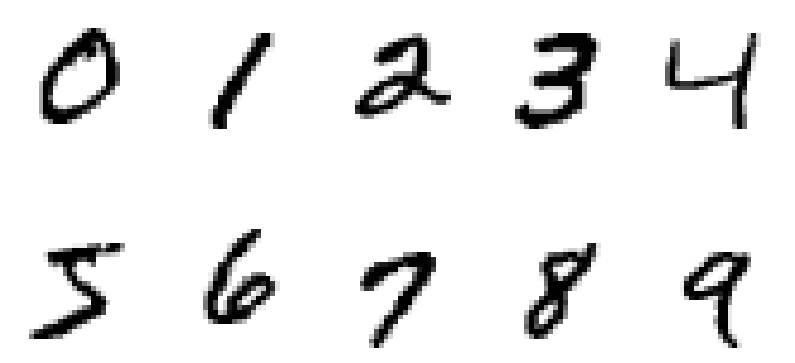

In [4]:
plt.figure(figsize=(10, 5))
for numero in range(0,10):
    sp = plt.subplot(2, 5, numero + 1)
    idx = (df.y == numero).argmax()
    plot_digit(df.X.loc[idx], subplot=sp)
plt.show()

### Binario 

Llevamos nuevamente a un problema binario, donde el dígito 5 corresponde a la clase positiva, y el resto a la negativa.

In [5]:
df['y_bin'] = (df.y == 5).astype(int)
df.head()

,X,y,y_bin
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0


Separamos 10 mil puntos al azar del dataset para utilizar como evaluación. 

In [6]:
df_train, df_test = train_test_split(df, test_size=10000, random_state=42)
df['train'] = df.index.isin(df_train.index)
df

,X,y,y_bin,train
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,True
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,True
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0,True
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,True
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0,False
...,...,...,...,...
69995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0,True
69996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,0,True
69997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0,True
69998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,True


### Entrenamiento

Definimos los atributos `X` y los target `y` de cada conjunto para entrenamiento y evaluación.

In [7]:
X_train = np.stack(df_train.X)
y_train = df_train.y_bin.values

X_test = np.stack(df_test.X)
y_test = df_test.y_bin.values

Y miramos el balance de clases.

In [8]:
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))

0.0896
0.0937


Ahora sí, entrenamos. El entrenamiento es similar al de la guía anterior, pero vamos a utilizar un `Pipeline` de Scikit-Learn.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

clf = LogisticRegression(C=0.1, penalty="l1", solver="saga", tol=0.1)

pipe = Pipeline([('scaler', StandardScaler()), ('clf', clf)])
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=0.1, penalty='l1', solver='saga',
                                    tol=0.1))])

## 2. Evaluación

Vamos a evaluar. Primero hacemos las predicciones correspondientes, y luego observamos la matriz de confusión y calculamos `accuracy`.

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [11]:
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

In [12]:
print(accuracy_score(y_train, y_train_pred))
confusion_matrix(y_train, y_train_pred)


0.9518333333333333


array([[52786,  1838],
       [ 1052,  4324]])

In [13]:
print(accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)

0.952


array([[8759,  304],
       [ 176,  761]])

Agregemos todo al DataFrame principal.

In [14]:
df['y_pred'] = pipe.predict(df.X.tolist())
df['y_pred_proba'] = pipe.predict_proba(df.X.tolist())[:, 1]
df

,X,y,y_bin,train,y_pred,y_pred_proba
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,True,1,0.684720
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,True,0,0.242268
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0,True,0,0.190331
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,True,0,0.216962
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0,False,0,0.134158
...,...,...,...,...,...,...
69995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0,True,0,0.149816
69996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,0,True,0,0.313376
69997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0,True,0,0.279001
69998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,True,1,0.933359


Comparemos los score predichos en cada conjunto, para aquellos que son realmente 5 y aquellos que no:

In [15]:
p_cincos_train = df.query('train and y == 5').y_pred_proba
p_no_cincos_train = df.query('train and y != 5').y_pred_proba

p_cincos_test = df.query('not train and y == 5').y_pred_proba
p_no_cincos_test = df.query('not train and y != 5').y_pred_proba

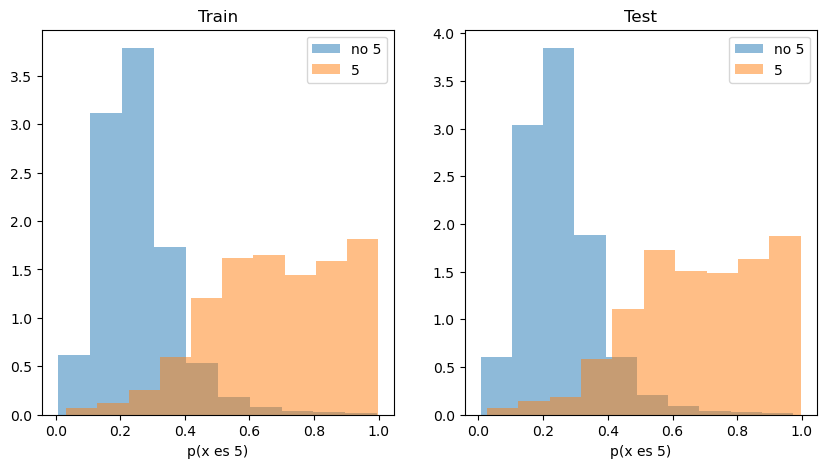

In [16]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

axs[0].set_title('Train')
axs[0].hist(p_no_cincos_train, label='no 5', alpha=0.5, density=True)
axs[0].hist(p_cincos_train, label='5', alpha = 0.5, density=True)
axs[0].set_xlabel('p(x es 5)')
# axs[0].set_yscale('log')
axs[0].legend()

axs[1].set_title('Test')
axs[1].hist(p_no_cincos_test, label='no 5', alpha = 0.5, density=True)
axs[1].hist(p_cincos_test, label='5', alpha = 0.5, density=True)
axs[1].set_xlabel('p(x es 5)')
# axs[1].set_yscale('log')
axs[1].legend()

plt.show()

Agreguemos al DataFrame si cada instancia se trata de un TP, un FP, etc.

In [17]:
def confusion_matrix_aux(y, y_pred, positive_class = 1):
    if y == positive_class:
        if y == y_pred:
            return 'TP'
        else:
            return 'FN'
    else:
        if y == y_pred:
            return 'TN'
        else:
            return 'FP'
        

In [18]:
df['hit'] = df['y_bin'] == df['y_pred']
df['confusion_matrix'] = df.apply(lambda x: confusion_matrix_aux(x['y_bin'], x['y_pred']), axis=1)
df

,X,y,y_bin,train,y_pred,y_pred_proba,hit,confusion_matrix
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,True,1,0.684720,True,TP
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,True,0,0.242268,True,TN
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0,True,0,0.190331,True,TN
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,True,0,0.216962,True,TN
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,0,False,0,0.134158,True,TN
...,...,...,...,...,...,...,...,...
69995,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0,True,0,0.149816,True,TN
69996,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,0,True,0,0.313376,True,TN
69997,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0,True,0,0.279001,True,TN
69998,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,True,1,0.933359,True,TP


In [19]:
df_results_test = df.query('not train')
df_results_test.confusion_matrix.value_counts()

TN    8759
TP     761
FP     304
FN     176
Name: confusion_matrix, dtype: int64

Veamos cómo son las disitrubuciones para los scores predichos según dónde están en la matriz de confusión. Asegurate de interpretar el gráfico.

<AxesSubplot: xlabel='y_pred_proba', ylabel='Count'>

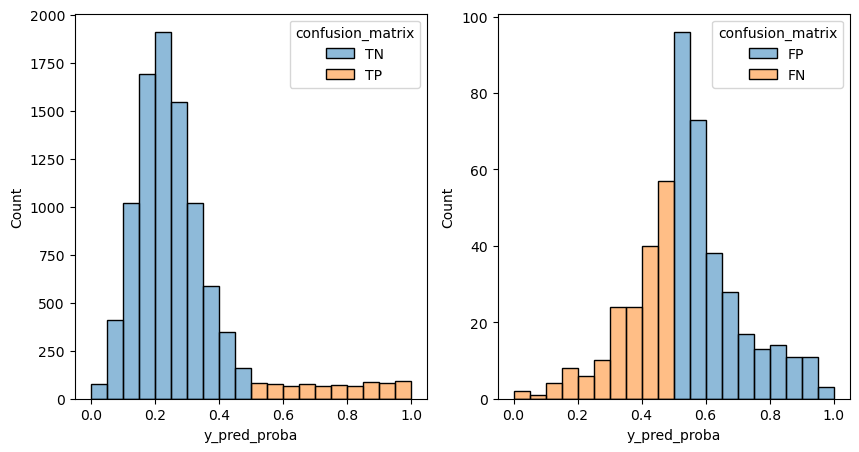

In [20]:
fig, axs = plt.subplots(1,2, figsize = (10,5))

sns.histplot(x = 'y_pred_proba', hue = 'confusion_matrix', 
             data = df_results_test.query('confusion_matrix == "TP" or confusion_matrix == "TN"'),
             bins = np.linspace(0,1,21),
             ax = axs[0])
sns.histplot(x = 'y_pred_proba', hue = 'confusion_matrix',
             data = df_results_test.query('confusion_matrix == "FP" or confusion_matrix == "FN"'),
             bins = np.linspace(0,1,21),
             ax = axs[1])

### Curva ROC *a mano*

Vamos a hacer una curva ROC *a mano*. Esto significa ir variando el umbral de clasificación sobre los scores predichos y calcular el TPR y FPR. ¿Cómo está relacionado con el gráfico anterior? A modo de recordatorio, la curva ROC es un gráfico de $TPR$ en función de $FPR$ para un modelo dado, donde

$TPR = \frac{VP}{VP + FN}$

$FPR = \frac{FP}{FP + VN}$

In [21]:
threholds = np.linspace(0, 1, 101)
TPR = []
FPR = []
precision = []
positives = df_results_test.y_bin.sum()
negatives = len(df_results_test) - positives

### AGREGAMOS UN SCORE RANDOM PARA SIMULAR UN MODELO ALEATORIO
df_results_test['random_score'] = np.random.uniform(0,1,size = len(df_results_test))
TPR_random = []
FPR_random = []

for threhold in threholds:
    predictions = (df_results_test.y_pred_proba >= threhold).astype(int)
    TP = ((df_results_test.y_bin == 1) & (predictions == 1)).sum()
    FP = ((df_results_test.y_bin == 0) & (predictions == 1)).sum()
    FN = ((df_results_test.y_bin == 1) & (predictions == 0)).sum()
    VN = ((df_results_test.y_bin == 0) & (predictions == 0)).sum()
    
    TPR.append(TP/positives)
    FPR.append(FP/negatives)
    precision.append(TP/(TP + FP))
    
    predictions_random = (df_results_test.random_score >= threhold).astype(int)
    TP = ((df_results_test.y_bin == 1) & (predictions_random == 1)).sum()
    FP = ((df_results_test.y_bin == 0) & (predictions_random == 1)).sum()
    FN = ((df_results_test.y_bin == 1) & (predictions_random == 0)).sum()
    VN = ((df_results_test.y_bin == 0) & (predictions_random == 0)).sum()
    
    TPR_random.append(TP/positives)
    FPR_random.append(FP/negatives)
    
    
TPR = np.array(TPR)
FPR = np.array(FPR)
precision = np.array(precision)

recall = TPR

/tmp/ipykernel_11417/4004593334.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results_test['random_score'] = np.random.uniform(0,1,size = len(df_results_test))
/tmp/ipykernel_11417/4004593334.py:22: RuntimeWarning: invalid value encountered in long_scalars
  precision.append(TP/(TP + FP))


Graficamos junto con la curva obtenida por Scikit-Learn

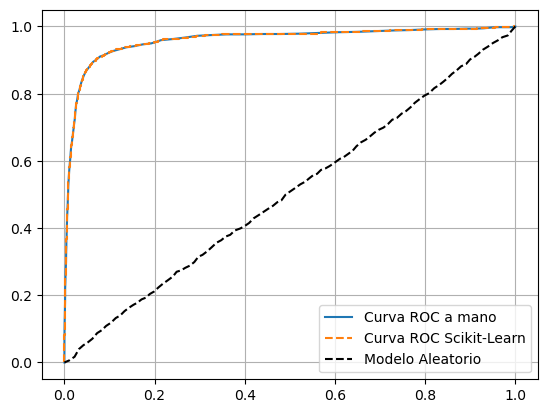

In [22]:
plt.plot(FPR, TPR, label = 'Curva ROC a mano')
fpr, tpr, _ = roc_curve(df_results_test.y_bin, df_results_test.y_pred_proba)
plt.plot(fpr, tpr, ls = '--', label = 'Curva ROC Scikit-Learn')
plt.plot(FPR_random, TPR_random, ls = '--',color = 'k', label = 'Modelo Aleatorio')
plt.grid()
plt.legend()


Y calculamos el área bajo la curva.

In [23]:
print(auc(fpr, tpr))
print(auc(FPR, TPR))
print(roc_auc_score(df_results_test.y_bin, df_results_test.y_pred_proba))

0.9592797058795476
0.9592459094885547
0.9592797058795476


### Otras métricas

Podemos ver cómo varían algunas métricas a medida que variamos el umbral

Text(0.5, 0, 'Umbral')

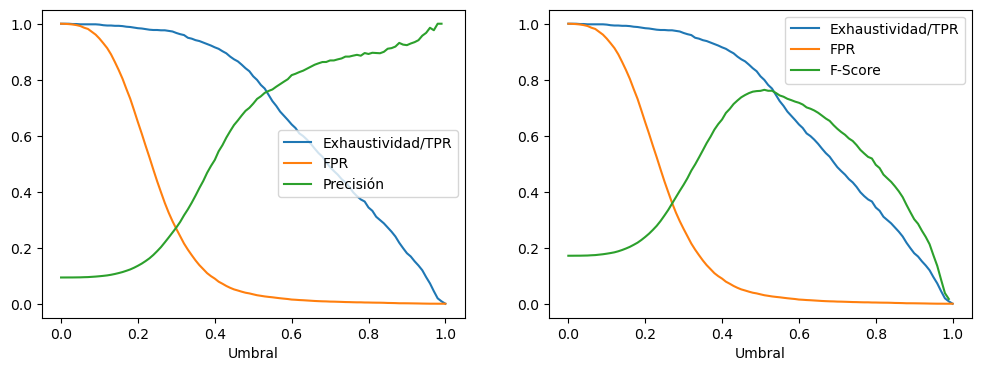

In [24]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
axs[0].plot(threholds, recall, label = 'Exhaustividad/TPR')
axs[0].plot(threholds, FPR, label = 'FPR')
axs[0].plot(threholds, precision, label = 'Precisión')


axs[0].legend()
axs[0].set_xlabel('Umbral')

axs[1].plot(threholds, recall, label = 'Exhaustividad/TPR')
axs[1].plot(threholds, FPR, label = 'FPR')
axs[1].plot(threholds, 2*(precision*recall)/(precision+recall), label = 'F-Score')

axs[1].legend()
axs[1].set_xlabel('Umbral')

La curva Precisión/Exhaustividad es otra curva que se pueden encontrar. Hay que tener cierta precausión con esta curva, porque depende del balance de clases a través de la precisión. Interpreta cada extremo de la curva.

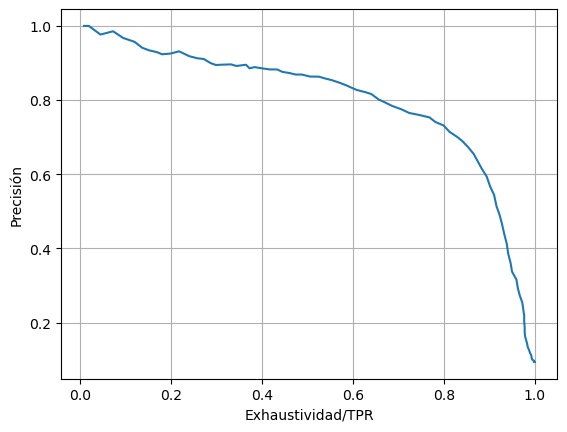

In [25]:
plt.plot(recall, precision)
plt.xlabel('Exhaustividad/TPR')
plt.ylabel('Precisión')
plt.grid()

## 3. Extra: Análisis de errores

Vamos a hacer, brevemente, un análisis de los errores. Esto significa seleccionar los Falsos Negativos y los Falsos Positivos e intentar comprender por qué se confunde el modelo.

### Falsos Negativos

In [26]:
df_results_test.query('confusion_matrix == "FN"')

,X,y,y_bin,train,y_pred,y_pred_proba,hit,confusion_matrix,random_score
182,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.473403,False,FN,0.313498
836,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.303498,False,FN,0.032185
1978,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.477420,False,FN,0.177904
2758,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.347327,False,FN,0.450252
3648,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.465430,False,FN,0.247914
...,...,...,...,...,...,...,...,...,...
67826,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.399240,False,FN,0.553126
67859,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.026157,False,FN,0.628101
67888,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.109473,False,FN,0.949813
69013,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,False,0,0.468778,False,FN,0.238567


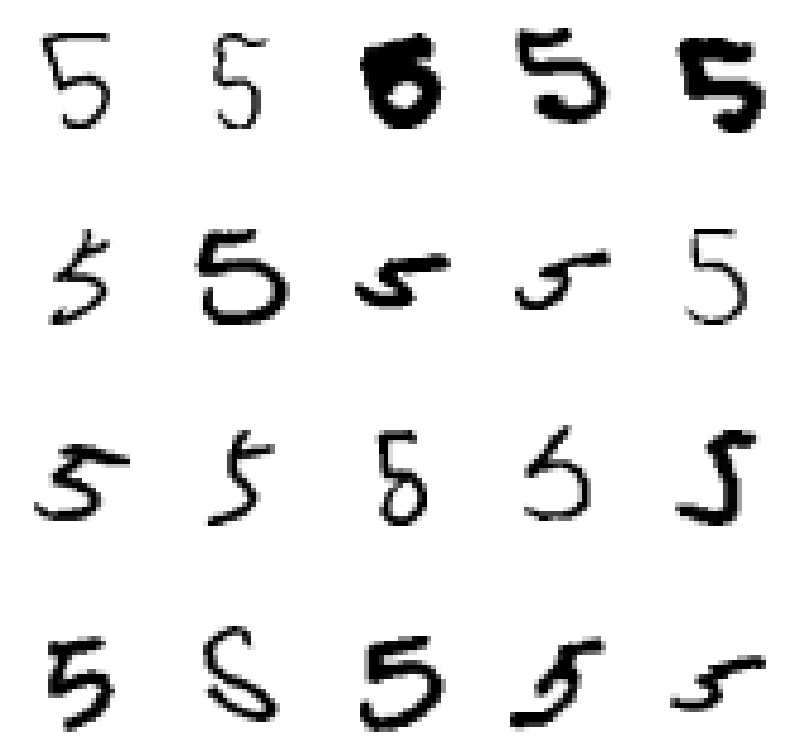

In [27]:
np.random.seed(42)
plt.figure(figsize=(10, 10))
for i,x in enumerate(df_results_test.query('confusion_matrix == "FN"').sample(20).X):
    sp = plt.subplot(4, 5, i + 1)
    
    plot_digit(x, subplot = sp)
plt.show()

### Falsos Positivos

In [28]:
df_results_test.query('confusion_matrix == "FP"')

,X,y,y_bin,train,y_pred,y_pred_proba,hit,confusion_matrix,random_score
127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,0,False,1,0.596769,False,FP,0.738098
161,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0,False,1,0.506807,False,FP,0.601299
469,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,0,False,1,0.879810,False,FP,0.737786
539,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,0,False,1,0.643543,False,FP,0.848094
874,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,0,False,1,0.502002,False,FP,0.462676
...,...,...,...,...,...,...,...,...,...
69213,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,0,False,1,0.595197,False,FP,0.591290
69700,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,0,False,1,0.505592,False,FP,0.817749
69714,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,False,1,0.519682,False,FP,0.837041
69761,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,False,1,0.734231,False,FP,0.318584


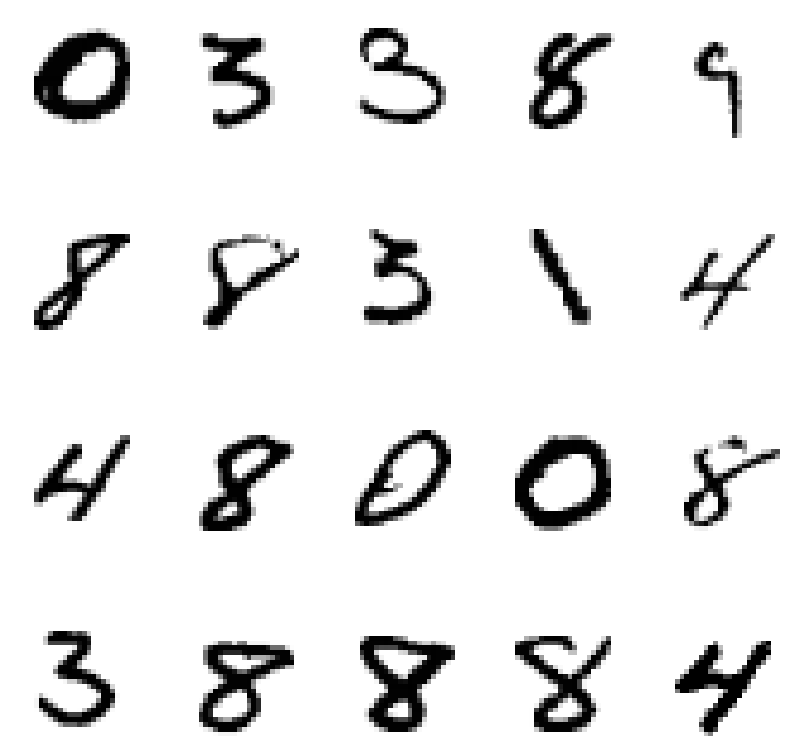

In [29]:
np.random.seed(42)
plt.figure(figsize=(10, 10))
for i,x in enumerate(df_results_test.query('confusion_matrix == "FP"').sample(20).X):
    sp = plt.subplot(4, 5, i + 1)

    plot_digit(x, subplot = sp)
plt.show()